<a href="https://colab.research.google.com/github/syoung7388/2023_MLCL_Bootcamp/blob/main/wav2vec2.0-based%20asr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#`음성인식 실습: wav2vec 2.0 model을 활용한 영어 음성인식 실습`



> 2023.02.14 / 경북대학교 인공지능학과 김준우 박사과정


> Q&A: kaen2891@gmail.com

## Overview

음성 인식 과정은 다음과 같음

1. 오디오 파형에서 음향 특징 추출

2. 프레임별로 음향 특징 추정

3. 클래스 확률의 시퀀스에서 가설(predicted_label) 생성




## Preparation

먼저 필요한 패키지를 가져오고 작업할 데이터를 가져옴




In [ ]:
# %matplotlib inline

import os

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

1.13.1+cu116
0.13.1+cu116
cuda


## Creating a pipeline

먼저 기능을 수행하는 wav2vec2 모델을 생성

wav2vec2 모델은 자체 지도 방식으로 학습됨

표현 학습을 위해 오디오로만 학습한 다음 추가 레이블이 있는 특정 작업에 대해 미세 조정됨

여기서는 :py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`를 사용




In [ ]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


모델은 다음과 같이 구성할 수 있고, 이 프로세스는 사전 훈련된 가중치를 자동으로 가져와 모델에 로드함

In [ ]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Loading data
아래의 데이터 중 1개만을 테스트 용도로 사용함 `VOiCES
dataset <https://iqtlabs.github.io/voices/>`




In [ ]:
IPython.display.Audio(SPEECH_FILE)

데이터를 로드하기위해 :py:func:`torchaudio.load`를 사용함

샘플링 속도가 파이프라인에서 예상하는 것과 다른 경우 리샘플링을 위해 :py:func:`torchaudio.functional.resample`을 사용할 수 있음




In [ ]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
print('waveform {} sample_rate {}'.format(waveform.size(), sample_rate))
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

waveform torch.Size([1, 54400]) sample_rate 16000


## 음향 특징 추출

다음 단계는 음성에서 음성 특징표현을 추출하는 것임

In [ ]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

반환된 특징표현은 텐서 목록이며, 각 텐서는 wav2vec2.0 모델의 계층 출력임

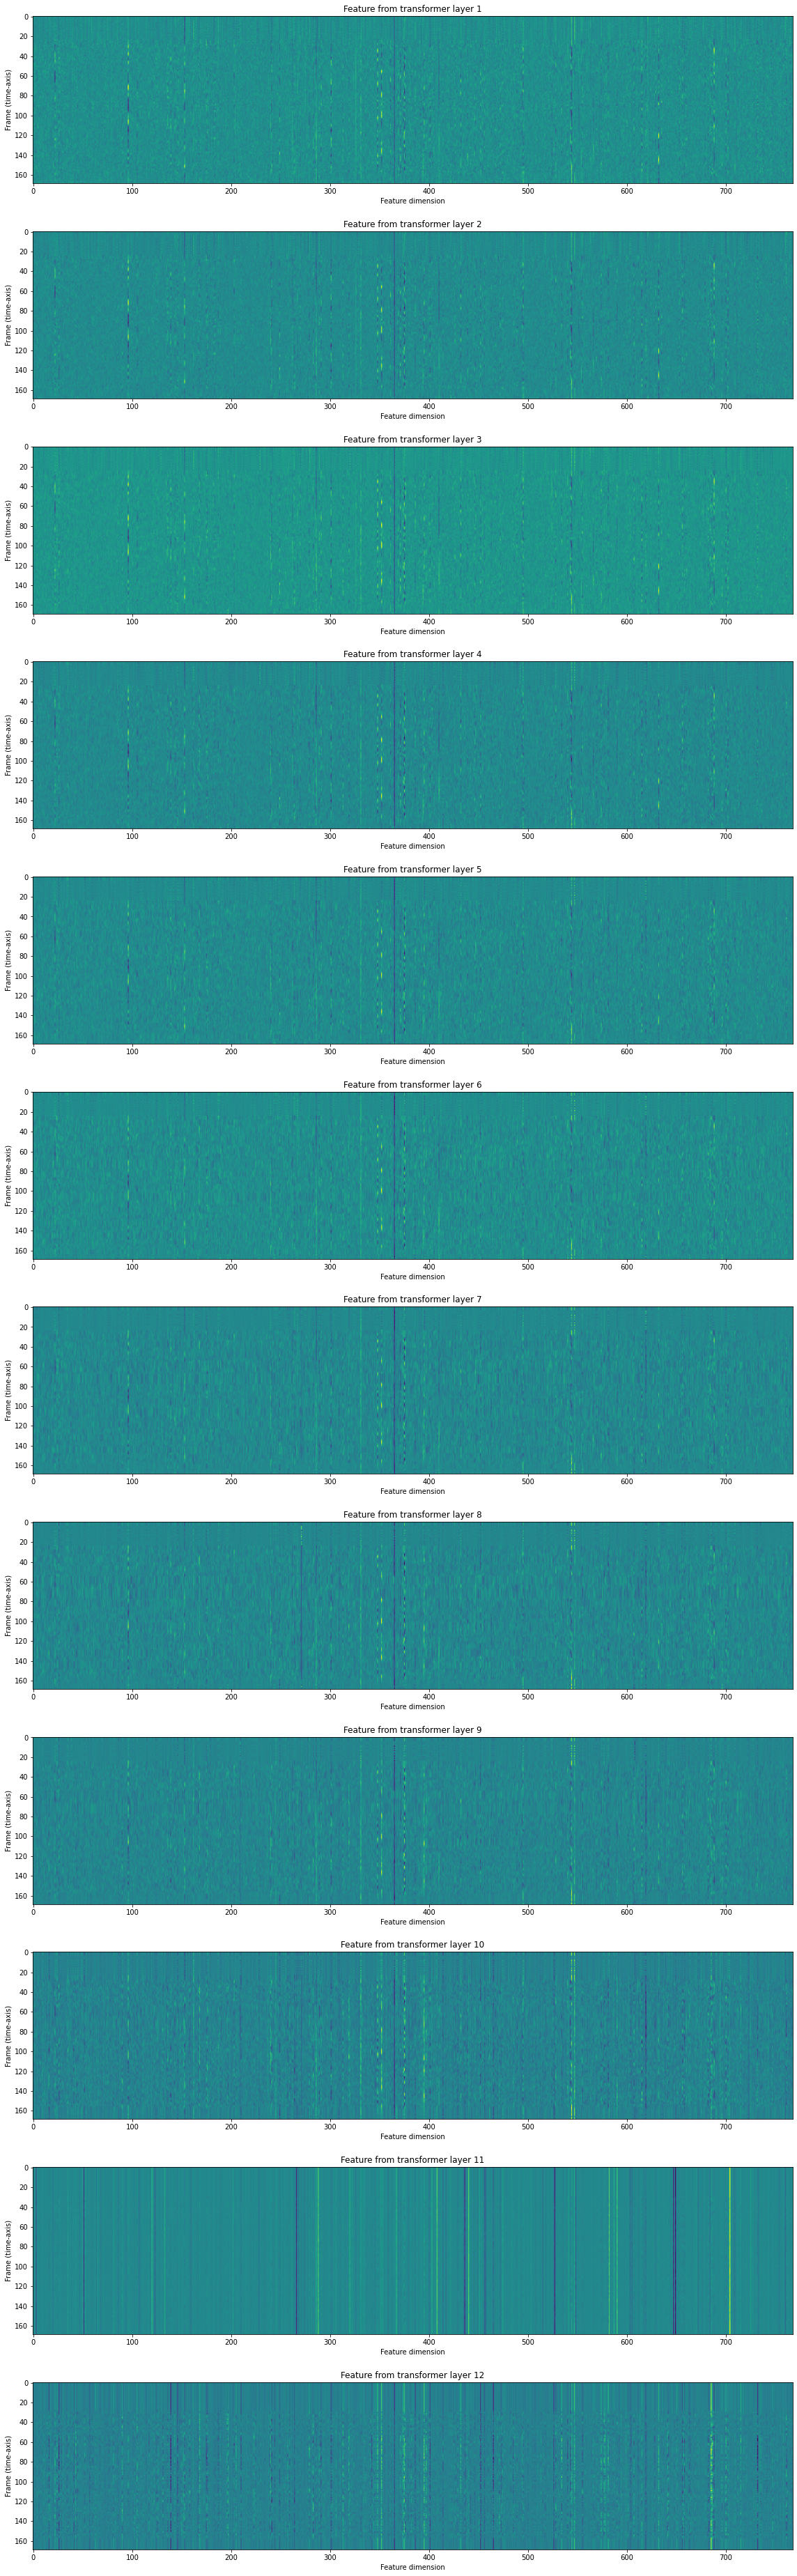

In [ ]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

## 특징 분류

음성 특징표현이 추출되면 다음 단계는 추출된 특징을 분류하는 것임. 

이를 위해 wav2vec2 모델은 특징 추출 및 분류를 한 번에 수행하는 방법을 제공함




In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

출력은 logit 형식이며, 확률의 형태가 아님

시각화해보면,

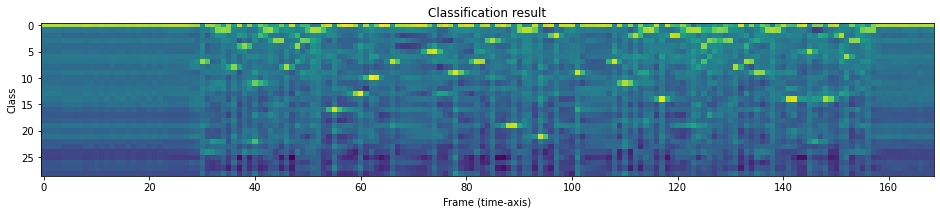

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [ ]:
plt.imshow(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

타임라인 전체에 걸쳐 특정 레이블에 대한 강력한 표시가 있음을 알 수 있음

## 스크립트 생성

레이블 시퀀스에서 전사체(음성인식)를 생성하려고 함. 

가설을 생성하는 프로세스를, 즉 주어진 입력 음성으로부터 텍스트를 만들어내는 것을 종종 "디코딩"이라고 함

디코딩은 단순한 분류보다 더 정교한데, 특정 시간 단계에서의 디코딩은 주변 관측에 의해 영향을 받을 수 있음

이 튜토리얼에서는 단순함을 위해 이러한 외부 구성 요소에 의존하지 않는 탐욕적인 (Greedy) 디코딩을 수행하고 각 시간 단계에서 단순히 최상의 가설을 선택함. 

따라서 컨텍스트 정보를 사용하지 않고 하나의 스크립트만 생성할 수 있음.

컨텍스트 정보를 사용하는것은 beam search라고 하는데, 본 튜토리얼에서는 greedy decoding만 진행



In [ ]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

이제 디코더 개체를 만들고 스크립트를 디코딩함

In [ ]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

print(transcript)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


Predicted ASR 결과 및 오디오 확인

In [ ]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


ASR 모델은 CTC(Connectionist Temporal Classification)라는 손실 함수를 사용하여 미세 조정됨 (CTC 손실에 대한 자세한 설명은: ` <https://distill.pub/2017/ctc/>`.)


CTC에서 공백 토큰(ϵ)은 이전 기호의 반복을 나타내는 특수 토큰인데, 디코딩에서는 무시됨




#실제로 음성인식 진행해보기

아래의 사이트 (http://www.voiptroubleshooter.com/open_speech/american.html)에 접속하여 wav 파일 주소를 넣음

In [ ]:
!wget https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0011_8k.wav

--2023-02-14 05:21:26--  https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0011_8k.wav
Resolving www.voiptroubleshooter.com (www.voiptroubleshooter.com)... 162.241.218.124
Connecting to www.voiptroubleshooter.com (www.voiptroubleshooter.com)|162.241.218.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524600 (512K) [audio/x-wav]
Saving to: ‘OSR_us_000_0011_8k.wav’

OSR_us_000_0011_8k. 100%[===================>] 512.30K  --.-KB/s    in 0.1s    

2023-02-14 05:21:26 (4.11 MB/s) - ‘OSR_us_000_0011_8k.wav’ saved [524600/524600]



In [ ]:
IPython.display.Audio('/content/OSR_us_000_0011_8k.wav')


In [ ]:

waveform, sample_rate = torchaudio.load('/content/OSR_us_000_0011_8k.wav')
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
transcript = decoder(emission[0])
print(transcript)
IPython.display.Audio('/content/OSR_us_000_0011_8k.wav')

THE|BOYER|WAS|THERE|WHEN|THE|SUN|ROSE|THE|ROD|IS|USED|TO|CATCH|PINK|SALMON|THE|SOREST|OF|THE|HOUE|RIVER|IS|THA|CLEAR|SPRING|KICKED|THE|BALL|STRIT|AND|FOLLOWED|THROUGH|HELP|THE|WOMAN|GET|BACK|TO|HER|SEAT|THE|POT|OF|TEA|HELPS|TO|PASS|TH|EVENING||SMOKY|FIRES|BLACK|FLAME|IN|HEAT|THE|SOFT|CUSHION|BROKE|THE|MAN'S|FALL|THE|SOFT|BREEZE|CAME|ACROSS|THA|SEAT|THE|GIRL|AT|THE|BOOT|SILL|FIFTY|BONDS|


In [ ]:
!wget https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0030_8k.wav

--2023-02-14 05:21:47--  https://www.voiptroubleshooter.com/open_speech/american/OSR_us_000_0030_8k.wav
Resolving www.voiptroubleshooter.com (www.voiptroubleshooter.com)... 162.241.218.124
Connecting to www.voiptroubleshooter.com (www.voiptroubleshooter.com)|162.241.218.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 750886 (733K) [audio/x-wav]
Saving to: ‘OSR_us_000_0030_8k.wav’

OSR_us_000_0030_8k. 100%[===================>] 733.29K  --.-KB/s    in 0.1s    

2023-02-14 05:21:47 (6.31 MB/s) - ‘OSR_us_000_0030_8k.wav’ saved [750886/750886]



In [ ]:
IPython.display.Audio('/content/OSR_us_000_0030_8k.wav')

In [ ]:
waveform, sample_rate = torchaudio.load('/content/OSR_us_000_0030_8k.wav')
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [ ]:
with torch.inference_mode():
    emission, _ = model(waveform)

In [ ]:
transcript = decoder(emission[0])
print(transcript)
IPython.display.Audio('/content/OSR_us_000_0030_8k.wav')

PAINT|THE|SOCKETS|IN|THE|WALL|DULL|GREEN|THE|CHILD|CRAWLED|INTO|THE|DENSE|GRASS|BRIBES|FAIL|WHERE|HONEST|MEN|WORK|TRAMPLE|THE|SPARK|ELSE|THE|FLAMES|WILL|SPREAD|THE|HILT|OF|THE|SWORD|WAS|CARVED|WITH|FINE|DESIGNS|A|ROUND|HOLE|WAS|DRILLED|THROUGH|THE|THIN|BOARD|FOOTPRINTS|SHOWED|THE|PATH|HE|TOOK|UP|THE|BEACH|SHE|WAS|WAITING|AT|MY|FRONT|LAWN|EVENT|NEAR|THE|EDGE|BROUGHT|IN|FRESH|AIR|PRAD|THE|OLD|MULE|WITH|A|CROOKED|STICK|


## 결론

이 튜토리얼에서는 Pre-trained Wav2Vec2.0 model을 사용하여 음성 특징표현 추출 및 인식 수행하는 방법을 살펴보았음



# Speech-to-Text (STT)

# Appendix
## Text-to-Speech

English version

In [ ]:
!pip install gTTS
from gtts import gTTS
eng_wav = gTTS('Hello World!') 
eng_wav.save('eng.wav')
import IPython
IPython.display.Audio('eng.wav')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.8 MB/s eta 0:00:00
  Attempting uninstall: six
    Found existing installation: six 1.15.0
    Uninstalling six-1.15.0:
      Successfully uninstalled six-1.15.0
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: click
    Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
flask 1.1.4 requires click<8.0,>=5.1, but you have c

Korean version

In [ ]:
kor_wav = gTTS('안녕 세상아!', lang = 'ko') 
kor_wav.save('kor.wav')
IPython.display.Audio('kor.wav')

In [ ]:
kor_wav2 = gTTS('이제 가을이 오나봐요 대구도 슬슬 시원해지고 있네요', lang = 'ko') 
kor_wav2.save('kor_wav2.wav')
IPython.display.Audio('kor_wav2.wav')

In [ ]:
kor_wav3 = gTTS('간장공장 공장장은 강공장장이고 공공장 공장장은 장공장장이다.', lang = 'ko') 
kor_wav3.save('kor_wav3.wav')
IPython.display.Audio('kor_wav3.wav')

In [ ]:
kor_wav4 = gTTS('킹갓엠페러제너럴충무공마제스티.', lang = 'ko') 
kor_wav4.save('kor_wav4.wav')
IPython.display.Audio('kor_wav4.wav')

In [ ]:
eng_wav2 = gTTS('King god emperor general chungmugong majesty', lang = 'en') 
eng_wav2.save('eng_wav2.wav')
IPython.display.Audio('eng_wav2.wav')